# **Multiclass classification model using a custom convolutional neural network in TensorFlow**

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Dataset:** The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

 - Actinic keratosis
 - Basal cell carcinoma
 - Dermatofibroma
 - Melanoma
 - Nevus
 - Pigmented benign keratosis
 - Seborrheic keratosis
 - Squamous cell carcinoma
 - Vascular lesion



### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
!python --version

Python 3.7.15


In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
#from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from glob import glob
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Data Reading/Data Understanding**

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
path_to_train_directory ='/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train'
path_to_test_directory = '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Test'
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## **Dataset creation**
- **Created train & validation dataset from the train directory with a batch size of 32.**
- **Resized images to 180*180.(10%)**

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
skin_cancer_class_names = train_ds.class_names
print(skin_cancer_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Dataset visualisation**
- **Created a code to visualize one instance of all the nine classes present in the dataset**

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

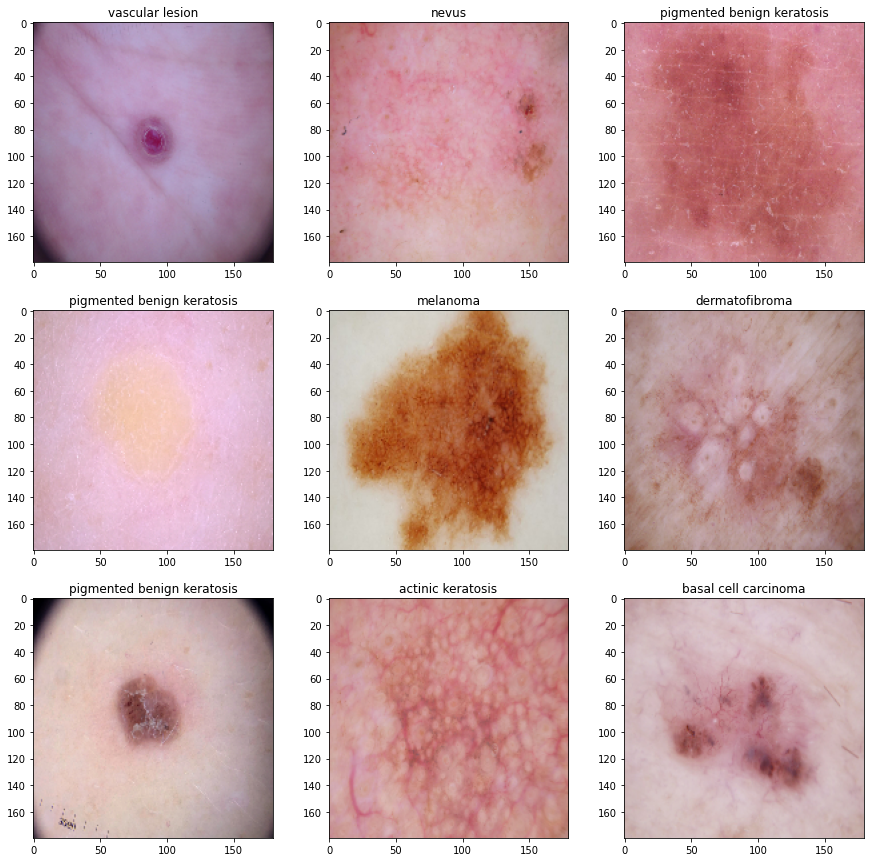

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1): #using training dataset
  for index in range(9):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(images[index].numpy().astype("uint8"))
    plt.title(skin_cancer_class_names[labels[index]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Model Building & training**
- **Created a CNN model, which can accurately detect 9 classes present in the dataset.**
- **Defined appropriate optimiser and loss function for model training.
Trained the model for ~20 epochs.**
- **Explained the findings after the model fit with evidence if the model overfits or underfits.**

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
input_shape = (180,180,3)
#we will be using is Sequential. Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
#  Used layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]
#  filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
#  kernel_size: An integer or tuple/list of 2 integers, specifying the height
#  and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) # 32 nodes/neurons
#using most popular kernal_size 3 X 3 https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))

# also ref - https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

**Compiling the model**
- Compiling the model takes three parameters: optimizer, loss and metrics.

- The optimizer controls the learning rate. We will be using ‘adam’ as our optmizer. Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.

- The learning rate determines how fast the optimal weights for the model are calculated. A smaller learning rate may lead to more accurate weights (up to a certain point), but the time it takes to compute the weights will be longer.

- Loss Function: Difference between categorical and binary cross entropy?:
  They are mathematically identical for 2 classes hence binary. In other words, 2 class categorical cross entropy is the same as single output binary cross entropy. To give a more tangible example these are identical:

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', ...)
  ##### *is the same as*
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', ...)
  
  Which one to use? To avoid one-hot encoding categorical outputs, if you only have 2 classes it is easier - from a coding perspective - to use binary cross entropy. The binary case might be computationally more efficient depending on the implementation.

To make things even easier to interpret, we will use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.

In [14]:
### Todo, choose an appropirate optimiser and loss function
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

In [16]:
#' ' means CPU whereas '/device:G:0' means GPU
#import tensorflow as tf
tf.test.gpu_device_name() # to check if GPU is being used because fit is taking longer sometimes.

'/device:GPU:0'

In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 16 14:29:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    26W /  70W |    842MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train the model

To train, we will use the ‘fit()’ function on our model with the following parameters: training data (train_ds), validation data (val_ds), and the number of epochs.

The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch. For our model, we will set the number of epochs to 20.

Note: deleted the files if code is run multiple times as more files are added due to data augmentation

In [18]:
#Trained the model for ~20 epochs.
epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 348s 2s/step - loss: -63089.0234 - accuracy: 0.1702 - val_loss: -60987.0820 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: -738089.8750 - accuracy: 0.1724 - val_loss: -625995.0000 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: -2712034.0000 - accuracy: 0.1724 - val_loss: -2314413.5000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 71ms/step - loss: -6766661.0000 - accuracy: 0.1724 - val_loss: -7197720.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: -13307579.0000 - accuracy: 0.1724 - val_loss: -13353706.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: -23306054.0000 - accuracy: 0.1724 - val_loss: -27293650.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss:

### Visualizing training results

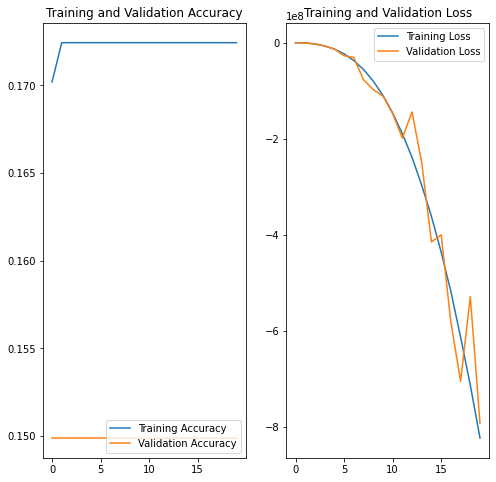

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

If training loss goes down and validation loss towards end of epochs increases - is called overfitting. it will perform worse in valiation data. Model memorise the data in training data set. and thus does not generalise to test data set. Opposite situation is called underfitting where the model does not have enough variables to solve the trainig dataset and more advancce model with more variables would perform better.

Overfitting or high variance in machine learning models occurs when the accuracy of your training dataset, the dataset used to “teach” the model, is greater than your testing accuracy. In terms of ‘loss’, overfitting reveals itself when your model has a low error in the training set and a higher error in the testing set. You can identify this visually by plotting your loss and accuracy metrics and seeing where the performance metrics converge for both datasets.


validation loss is below the training loss
training accuracy is better than validation accuracy
validation is jumping up and down due to limited data
Validation loss is lower because we are using dropout of 0.5
Assumption: Going ahead with this model. we could have used different dense, split(seed) of data or different value of dropout
to find different changes in validation and training loss.

in case of underfitting validation and training error is very high (loss), 
means model cannot learn from the training data. 
But where loss is reducing with more epochs, model may be able to learn with more epochs.

Overfitting : validation error is higher than training error
Model is not generalized to be able to work on real life datasets.
Dropout helps with generalizing the model.

During training, a perccentage of the feaures are set to zero, during testing all neurons are used.
So the model during testing is more robust and can lead to higher testing accuracies.


If both are converging eventually then goot fit.


### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

loss, accuracy = cnn_model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = cnn_model.evaluate(val_ds, verbose=1)
#verbose=2 means separate progressbars for epochs and batches
#1 means clear batch bars when done. 0 means only show epochs (never show batch bars)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 16ms/step - loss: -792294272.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -773939584.0
Validation Loss -792294272.0


**Overfitting or high variance in machine learning models occurs when the accuracy of your training dataset is greater than your testing accuracy. 
In terms of ‘loss’, model has low error in training set and higher error in testing dataset.
You can identify this visually in above plot.**

# Thus we can clearly state that model Overfit (accuracy on train data > test accuracy in test data) and we need to chose right data augumentation strategy

# **Data Augmentation**

**Data Augmentation using Keras ImageDataGenerator**

- **Keras ImageDataGenerator is this type of data augmentation. Take a batch of images used for training. Apply random transformations to each image in the batch. Replacing the original batch of images with a new randomly transformed batch.**

In [21]:
# tf.keras.preprocessing.image.ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation
# ref - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

#flow_from_directory: Takes the path to a directory & generates batches of augmented data.
train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


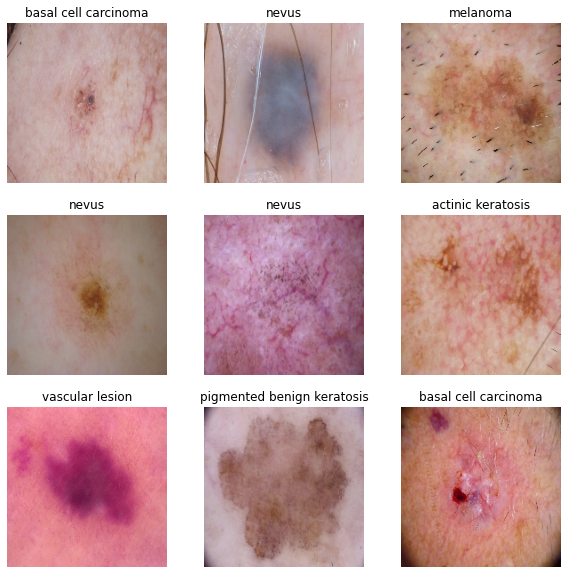

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(skin_cancer_class_names[labels[i]])
    plt.axis("off")

# **Model Building & training**

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = tf.keras.models.Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_13 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

### Compiling the model

In [25]:
## Your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
history = model.fit(train_batches, epochs = 20, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
35/35 [==============================] - 118s 3s/step - loss: 2.6839 - accuracy: 0.1822 - val_loss: 2.1643 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - 63s 2s/step - loss: 2.0277 - accuracy: 0.1925 - val_loss: 2.2176 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - 63s 2s/step - loss: 2.0295 - accuracy: 0.1992 - val_loss: 2.1870 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - 63s 2s/step - loss: 2.0373 - accuracy: 0.1992 - val_loss: 2.2404 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 5/20
35/35 [==============================] - 63s 2s/step - loss: 2.0343 - accuracy: 0.1809 - val_loss: 2.2138 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 6/20
35/35 [==============================] - 63s 2s/step - loss: 2.0119 - accuracy: 0.2193 - val_loss: 2.3062 - val_accuracy: 0.2288 - lr: 0.0010
Epoch 7/20
35/35 [==============================] - 63s 2s/step - loss: 1.8858 - 

### Visualizing the results

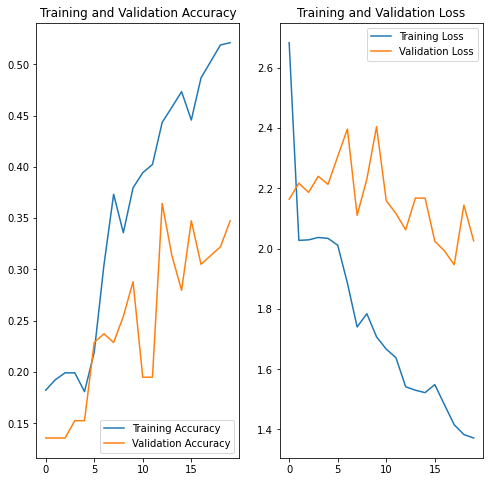

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
loss, accuracy = cnn_model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = cnn_model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 16ms/step - loss: -792294272.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -773939264.0
Validation Loss -792294272.0


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# **Class distribution**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

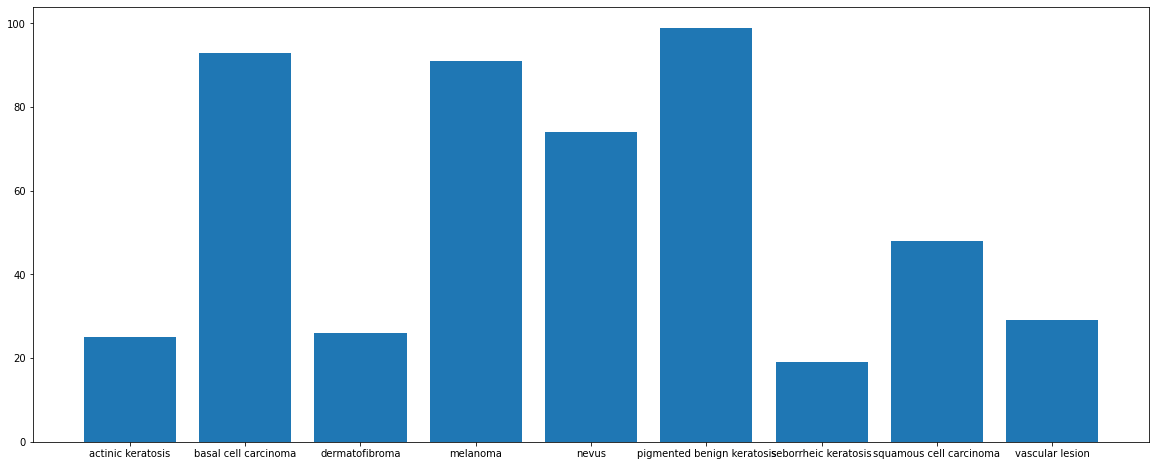

In [30]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in skin_cancer_class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[skin_cancer_class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? **Actinic Keratosos and Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? **Pigmented benign keratosis dominates the data of count more than 100 in training**

# **Handling class imbalances**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/"
import Augmentor
for i in skin_cancer_class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10C592D390>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10C5A9DDD0>: 100%|██████████| 500/500 [00:23<00:00, 21.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10C257FDD0>: 100%|██████████| 500/500 [00:24<00:00, 20.83 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F10C597A790>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10C24CAB10>: 100%|██████████| 500/500 [01:21<00:00,  6.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11B32CCE10>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F10C592D490>: 100%|██████████| 500/500 [00:44<00:00, 11.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10DC4762D0>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11415BE050>: 100%|██████████| 500/500 [00:19<00:00, 25.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_d57c1397-bbd0-4ed0-b06c-e41e89757848.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_839c3d6a-5481-4d5f-96aa-591302931b0f.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_99a326bc-ca60-4b51-afcc-edbfd3b9f179.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_0e6b7c7c-021f-4b98-9daf-5e04b4cf29b7.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032199.jpg_023e683b-3edc-413d-a7c9-6c39c57e007f.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train/actinic keratosis/output/actinic keratosis_o

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = df2

In [38]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# **Model Building & training**

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = "/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here
model = tf.keras.models.Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_28 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_30 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 41s 223ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 37s 211ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 37s 210ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/30
168/169 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1334
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 37s 210ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 37s 210ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-04
E

#### **Todo:**  Visualize the model results

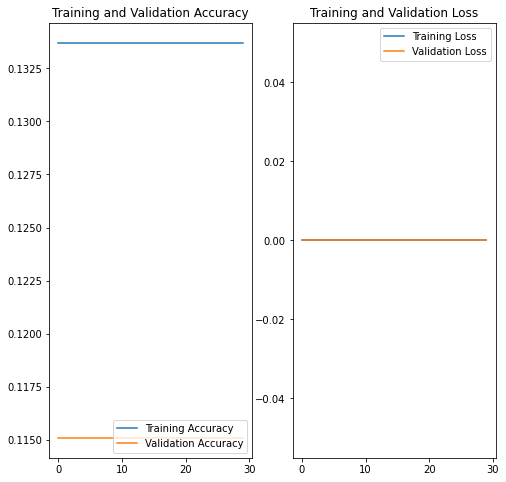

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 7s 133ms/step - loss: 0.0000e+00 - accuracy: 0.1151
Accuracy:  0.1337166130542755
Validation Accuracy:  0.11507052928209305
Loss:  0.0
Validation Loss 0.0


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Overfitting reduced by using the class rebalance and thus the loss is being reduced (loss is zero). But it reduced the Acurracy low to 0.115.

- Then we introduced dropout and ImageDataGenerator which reduced the over fit.
Keras ImageDataGenerator is this type of data augmentation. Take a batch of images used for training. Apply random transformations to each image in the batch. Replacing the original batch of images with a new randomly transformed batch.

- Normalization and Augumentation also helped.